# Clustering Time Series using MPdist

This tutorial replicates figure 5 from [Matrix Profile XII](https://ueaeprints.uea.ac.uk/id/eprint/69244/1/ICDM_2018_Shaghayegh.pdf). The figure compares results from hierarchical clustering time series under two different measures: the Euclidean distance and matrix profile distance (MPdist).

### What is MPdist?

Informally, MPdist can be described as encoding the similarity of the subsequences of two time series. For instance, if two time series is made up of the same repeating subsequences of window length `m`, then they would MPdist of 0 (if window size for MPdist is set to `m`), even if they are phase shifted. On the other hand, the Euclidean distance would be non-zero as long as they are phase shifted.

More concretely, given a threshold `percentage` and window length `m`, the MPdist between two time series is the smallest number such that it is higher than the specified `percentage` of the pairwise distances in the join matrix profile for the two time series parameterized by window size `m`. 

## Getting Started

We begin by importing STUMPY, some relevant packages for loading and analyzing the data.

In [1]:
import stumpy

# Data loading
from scipy.io import loadmat
from zipfile import ZipFile
from urllib.request import urlopen
import io
import ssl

# Data processing, clustering and plotting
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


Before diving into our main example, we would like to test our initial assertion that two phase-shifted time series with the same repeating subsequence would have MPdist 0. Here we generate a random motif of length 20 repeated 5 times. Then, we take two subsequence from within this so that they are just phase shifted form of each other. Despite being very similar to each other, we immediately notice that the Euclidean distance is non-zero. However, due to our definition of MPdist, each subsequnce of length 20 (or even higher window length) would have a subsequence that exactly matches that in the other time series. So, MPdist here is 0. Although this is a contrived case, it illustrates the limitation of using Euclidean distance to encode similarity between time series.

We use a slightly higher window length than the original motif of 30 and use a threshold of 0.05.

A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.
A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


Euclidean Distance:  166.85023224436938
MPdist:  0.0


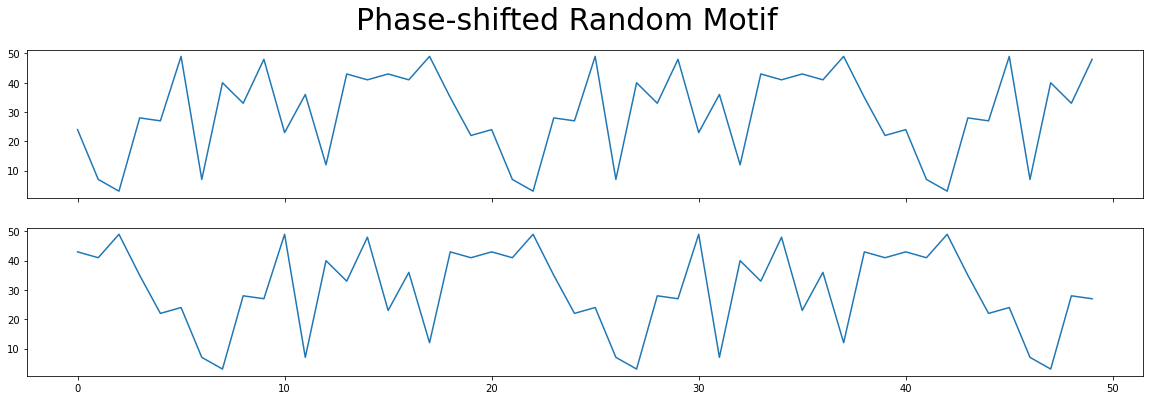

In [2]:
motif = np.floor(np.random.rand(20) * 50)
base = np.tile(motif, 5) # generates a longer sequence to choose two phase-shifted subsequences from

t_1 = base[:50]
t_2 = base[15:65]

plt.style.use('stumpy.mplstyle')

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.2})
plt.suptitle('Phase-shifted Random Motif', fontsize='30')

axs[0].plot(t_1)
axs[1].plot(t_2)

euc_dist = np.linalg.norm(t_1 - t_2)
mp_dist = stumpy.mpdist(t_1, t_2, 30, percentage=0.05)

print("Euclidean Distance: ", euc_dist)
print("MPdist: ", mp_dist)

## Loading the data

We load the data from the [companion website](https://sites.google.com/site/mpdistinfo) of the MPdist paper as pandas dataframes. The dataset is for handwriting data for some common American names.

In [3]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity

fzip = ZipFile(io.BytesIO(urlopen("https://sites.google.com/site/mpdistinfo/home/words_dendrogram.zip?attredirects=0&d=1").read()))
mat = fzip.extract("words_dendrogram/LisaBeth/MaryBethAnhLisa_data.mat")
data = loadmat(mat)

dfs = {}
for i in range(data['XSsY4'][0].shape[0]):
    name = data['XSsY4'][1][i][0]
    df = pd.DataFrame(data['XSsY4'][0][i].flatten(), columns=[name])
    dfs[name] = df


We then plot these time series. Each time series corresponds to a single name indicated on the right. The plot represents the Y-axis over time as the names are written out in cursive form.

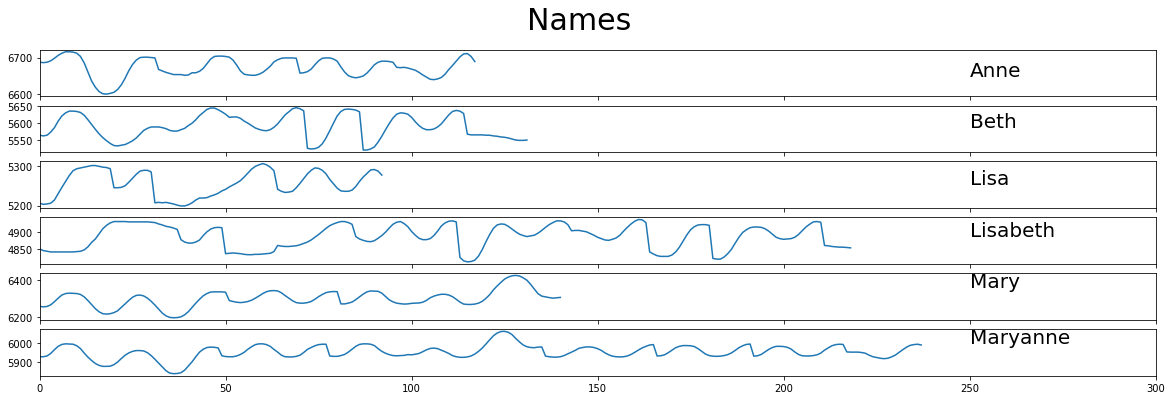

In [4]:
plt.style.use('stumpy.mplstyle')

fig, axs = plt.subplots(len(dfs), sharex=True, gridspec_kw={'hspace': 0.2})
plt.suptitle('Names', fontsize='30')

labels = [None] * len(dfs)

for i, (k, v) in enumerate(dfs.items()):
    ymax = v.max()
    axs[i].set_xlim(0, 300)
    axs[i].plot(v)
    name = k.replace("nh", "nne") # for some reason "nne" seems to be replaced by "nh" in the names
    axs[i].text(250, 0.99 * ymax, name, color="black", fontsize=20)
    labels[i] = name

## Clustering the Series

In order to begin clustering the series, we first compute the distance matrices. Entry (i, j) in a distance matrix corresponds to the distance between time series i and j under some measure. In this case, we compute a distance matrices for the MPdist. The MPdist is computed by simply calling `stumpy.mpdist` with the two time series, a window length of `30` and a threshold of `0.05`.

In [5]:
mp_distance_matrix = np.zeros((len(dfs),len(dfs)))

for i, (k_1, v_1) in enumerate(dfs.items()):
    v_1 = v_1.to_numpy()[:, 0].astype(float)
    for j, [k_2, v_2] in enumerate(dfs.items()):
        v_2 = v_2.to_numpy()[:, 0].astype(float)
        if not i == j:
            mp_distance_matrix[i, j] = stumpy.mpdist(v_1, v_2, 30, percentage=0.05)

In [6]:
# Clusters the data and plots it from distance matrix
def plot_cluster(distance_matrix):
    linked = linkage(squareform(distance_matrix), 'complete') 

    fig = plt.figure(figsize=(15, 12))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)


    ax = plt.Subplot(fig, outer[1])

    x = dendrogram(linked,
                orientation='right',
                labels=labels,
                distance_sort='descending',
                show_leaf_counts=False,
                ax=ax)
    fig.add_subplot(ax)
    inner = gridspec.GridSpecFromSubplotSpec(len(dfs), 1, subplot_spec=outer[0],
                                                 wspace=0.1, hspace=0.1)
    
    for i, name in enumerate(x['ivl'][::-1]):
        ax = plt.Subplot(fig, inner[i])
        ax.set_xlim(0, 250)
        fig.add_subplot(ax)

        ax.axis("off")
        key = name.replace('nne', 'nh')
        ax.plot(dfs[key])

    plt.show()

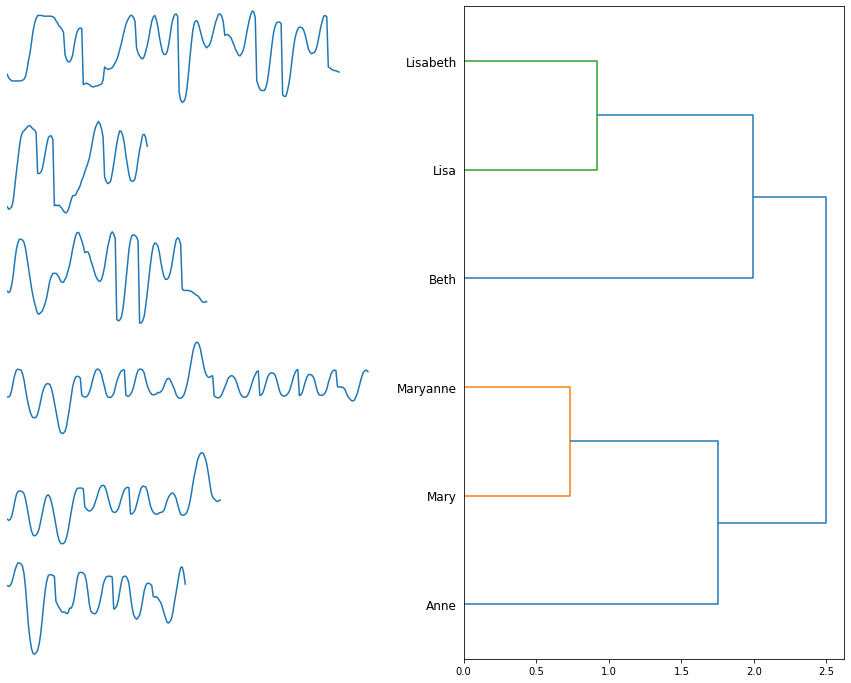

In [7]:
plot_cluster(mp_distance_matrix)

A careful observation reveals that the hierarchical cluster slightly deviates from the original figure from the paper (in the original figure, Lisa and Beth is swapped). This is owing to a mistake in the paper as acknowledged in its [supporting website](https://sites.google.com/site/mpdistinfo/) - the code that generated the original figure used 0.5 as its threshold instead of 0.05. Nevertheless, the three names (Lisa, Beth and Lisabeth) are still within the same large cluster.